# Spectral Normalized Gaussian Process (SNGP) Classification

In [1]:
import os
import tempfile
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from gpytorch.mlls import VariationalELBO
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger

from lightning_uq_box.datamodules import TwoMoonsDataModule
from lightning_uq_box.models.fc_resnet import FCResNet
from lightning_uq_box.uq_methods import SNGPClassification
from lightning_uq_box.viz_utils import (
    plot_predictions_classification,
    plot_training_metrics,
    plot_two_moons_data,
)

%load_ext autoreload
%autoreload 2

In [2]:
seed_everything(2)
# temporary directory for saving
my_temp_dir = tempfile.mkdtemp()

Seed set to 2


## Datamodule

In [3]:
dm = TwoMoonsDataModule(batch_size=100)

In [4]:
# define data
X_train, y_train, X_test, y_test, test_grid_points = (
    dm.X_train,
    dm.y_train,
    dm.X_test,
    dm.y_test,
    dm.test_grid_points,
)

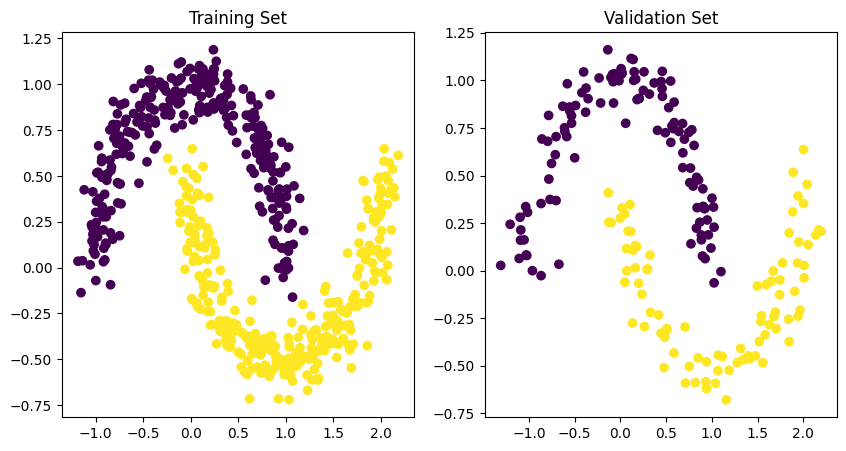

In [5]:
fig = plot_two_moons_data(X_train, y_train, X_test, y_test)

## Model

In [10]:
feature_extractor = FCResNet(input_dim=2, features=64, depth=4)

In [11]:
sngp = SNGPClassification(
    feature_extractor=feature_extractor,
    loss_fn=torch.nn.CrossEntropyLoss(),
    num_targets=2,
    mean_field_factor=2,
)

## Trainer

In [12]:
logger = CSVLogger(my_temp_dir)
trainer = Trainer(
    max_epochs=100,  # number of epochs we want to train
    logger=logger,  # log training metrics for later evaluation
    log_every_n_steps=1,
    enable_checkpointing=False,
    enable_progress_bar=False,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [13]:
trainer.fit(sngp, dm)


  | Name              | Type                  | Params
------------------------------------------------------------
0 | feature_extractor | FCResNet              | 16.8 K
1 | loss_fn           | CrossEntropyLoss      | 0     
2 | normalize         | LayerNorm             | 256   
3 | rff               | RandomFourierFeatures | 0     
4 | beta              | Linear                | 2.0 K 
5 | train_metrics     | MetricCollection      | 0     
6 | val_metrics       | MetricCollection      | 0     
7 | test_metrics      | MetricCollection      | 0     
------------------------------------------------------------
19.1 K    Trainable params
0         Non-trainable params
19.1 K    Total params
0.077     Total estimated model params size (MB)


/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
`Trainer.fit` stopped: `max_epochs=100` reached.


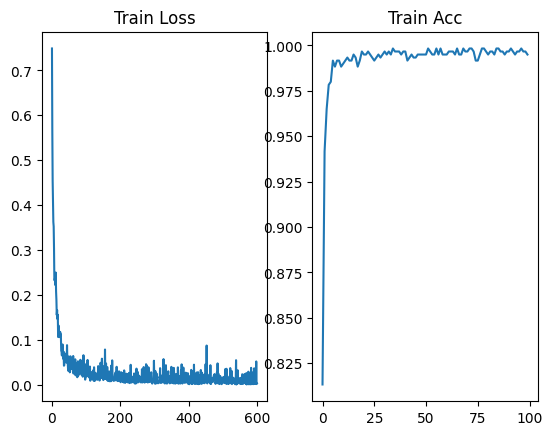

In [14]:
fig = plot_training_metrics(os.path.join(my_temp_dir, "lightning_logs"), "Acc")

In [15]:
preds = sngp.predict_step(test_grid_points)

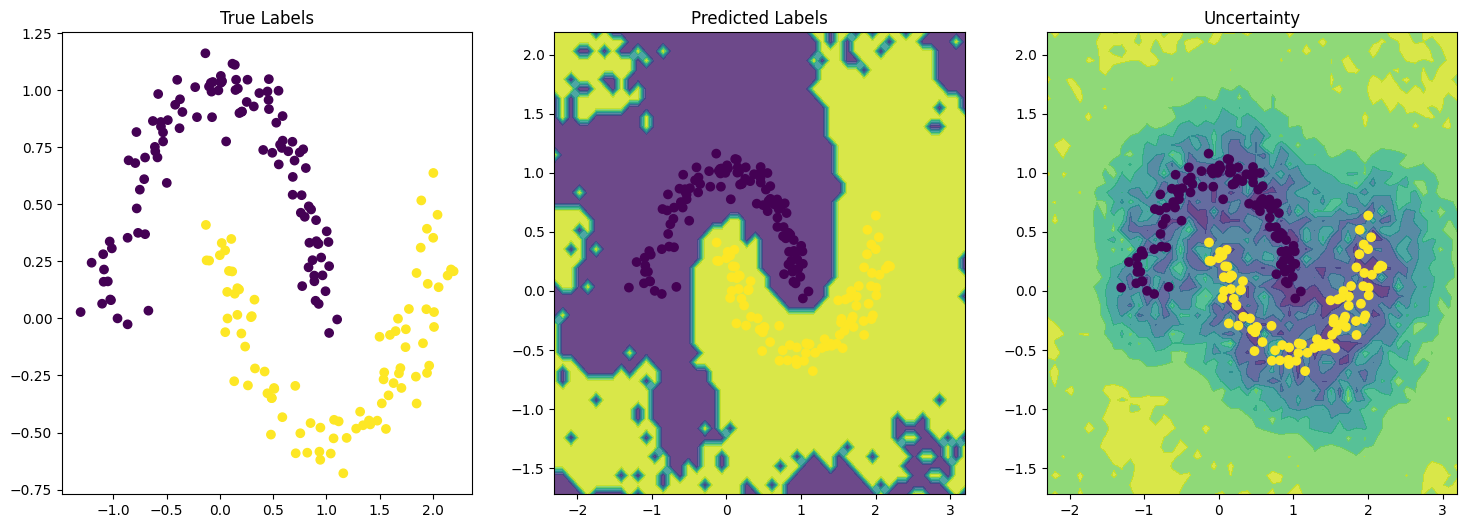

In [16]:
fig = plot_predictions_classification(
    X_test, y_test, preds["pred"].argmax(-1), test_grid_points, preds["pred_uct"]
)